In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pythreejs import *
from IPython.display import display

import lorm
from nfft import nfft
import disc.energy_curveling_3d

In [2]:
# load spock data and produce bluerred version of the samples
M = 100
x = np.linspace(-0.5,0.5,M,endpoint=False)
x1,x2,x3 = np.meshgrid(x,x,x)
quat_nodes = np.array([x3.ravel()[:],x1.ravel()[:],x2.ravel()[:]]).transpose()
def compute_spock_voxel_data():    
    sample = 1.2*(np.loadtxt('data/spock.uo')-np.array([0.5,0.5,0.45]))
    mu = np.zeros([M**3],dtype=np.float)
    # generate sampling of blurred spock: "spock_voxel.txt"
    for s in sample:
        mu[:] += np.exp(-30000*((quat_nodes[:,0]-s[1])**2+(quat_nodes[:,1]-s[2])**2+(quat_nodes[:,2]+s[0])**2))
    plt.imshow(mu.reshape([M,M,M])[:,:,10],vmin=0)#,vmax=1)
    np.savetxt('data/spock_voxel.txt',mu)
    
#uncomment if "spock_voxel.txt" not already computed
#compute_spock_voxel_data()

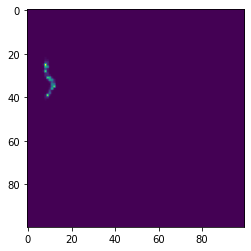

In [3]:
# load the data
mu=np.loadtxt('data/spock_voxel.txt')
M=int(mu.shape[0]**(1./3))+1
plt.imshow(mu.reshape([M,M,M])[:,:,10],vmin=0)#,vmax=1)

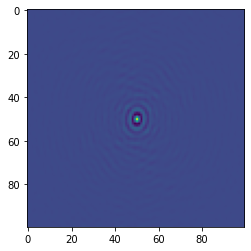

In [4]:
# compute the Fourier coefficients
mu_N_half = 50
nfft3d = nfft.NFFT3D(M**3,2*mu_N_half,2*mu_N_half,2*mu_N_half)
nfft3d.x = quat_nodes
nfft3d.precompute_x()
nfft3d.f = mu/M**3
nfft3d.adjoint()
mu_hat = np.zeros([2*mu_N_half,2*mu_N_half,2*mu_N_half],dtype=np.complex)
mu_hat[:] = nfft3d.f_hat/nfft3d.f_hat[mu_N_half,mu_N_half,mu_N_half]
plt.imshow(np.real(mu_hat[:,mu_N_half,:]))

In [5]:
# initialize the initial points
e3 = lorm.manif.EuclideanSpace(3)
points = lorm.manif.ManifoldPointArray(e3)
m = 100
points.coords = np.zeros([m,3])
t = np.linspace(0,2*np.pi,m,endpoint=False)
points.coords[:,0] = 0.3*np.sin(t)
points.coords[:,1] = 0.3*np.cos(t)
points.coords[:,2] = 0.3*np.sin(2*t)
points_new = lorm.manif.ManifoldPointArray(e3)

In [6]:
# setup the energy functional
N_half = 8
N=2*N_half
energy = disc.energy_curveling_3d.plan(m,N,0.1,10)
if mu_N_half >= N_half:
    energy._mu_hat[:] = mu_hat[mu_N_half-N_half:mu_N_half+N_half,mu_N_half-N_half:mu_N_half+N_half,mu_N_half-N_half:mu_N_half+N_half]
else:
    energy._mu_hat[N_half-mu_N_half:N_half+mu_N_half,N_half-mu_N_half:N_half+mu_N_half,N_half-mu_N_half:N_half+mu_N_half] = mu_hat[:]

In [7]:
# interactive rendering setup
g1 = BufferGeometry(attributes={'position': BufferAttribute(points.coords, normalized=False) })
m1 = LineBasicMaterial(vertexColors='VertexColors', linewidth=3)
line1 = Line(g1,m1)

c = PerspectiveCamera(position=[0, 2, 2], up=[0, 2, 0],
                      children=[DirectionalLight(color='white', position=[3, 5, 1], intensity=0.5)])

scene = Scene(children=[line1, c, AmbientLight(color='#777777')])

renderer = Renderer(camera=c,
                    scene=scene, 
                    controls=[OrbitControls(controlling=c)])
renderer.width =400
renderer.height =400
display(renderer)

def update_points(p):
    g1.attributes['position'].array = p.coords

/home/grman/.local/lib/python3.8/site-packages/pythreejs/traits.py:191: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(3.0, 5.0,…

In [8]:
# compute a local minimizer
method = lorm.optim.ConjugateGradientMethod(max_iter=100)
method.listener = update_points
for i in range(5):
    points = method.run(energy,points)

Initial value: f[0] = 0.39963415799543245
f[1] = 0.24463837191888782
f[2] = 0.18450305694840474
Line search failed!
Initial value: f[0] = 0.18450305694840474
f[1] = 0.12914050030626067
f[2] = 0.12555876301493035
f[3] = 0.11502699591415046
f[4] = 0.10862826252885911
f[5] = 0.10626816913197175
f[6] = 0.10067382589371357
f[7] = 0.08690033433146407
f[8] = 0.0788475257811429
f[9] = 0.06961647054273819
f[10] = 0.0630277371479484
f[11] = 0.06099316110263376
f[12] = 0.059821626855060546
f[13] = 0.05756138298702919
f[14] = 0.05400171668492384
f[15] = 0.04924279792361515
f[16] = 0.04579808035131377
f[17] = 0.04494421893718978
f[18] = 0.04367828861153467
f[19] = 0.041784740541328434
f[20] = 0.04041981666845877
f[21] = 0.03897789058020921
f[22] = 0.03786374465353758
f[23] = 0.03641861769921121
f[24] = 0.03538603936517013
f[25] = 0.03433526339829502
f[26] = 0.03315580919949084
f[27] = 0.03187110893169204
f[28] = 0.030886012261191725
f[29] = 0.03009533028893192
f[30] = 0.029444276859267888
f[31] = 0

f[78] = 0.010541703952551464
f[79] = 0.010532080916454663
f[80] = 0.010524757459918628
f[81] = 0.01051851016541697
f[82] = 0.010511537120879958
f[83] = 0.010505529588265679
f[84] = 0.010501429222243558
f[85] = 0.01049775855920847
f[86] = 0.010494418613766118
f[87] = 0.010489566414319912
f[88] = 0.010483757821484715
f[89] = 0.010474252592299468
f[90] = 0.010448173506519125
f[91] = 0.01041395943723498
f[92] = 0.01037190714301965
f[93] = 0.010335174955438276
f[94] = 0.010311224187881867
f[95] = 0.010289518612277143
f[96] = 0.010269597517213194
f[97] = 0.010253872185900912
f[98] = 0.010232830461977574
f[99] = 0.010206238257840781
f[100] = 0.01018351265308051
Reached maximal iterations!
Initial value: f[0] = 0.01018351265308051
f[1] = 0.010172007309284801
f[2] = 0.010162080248252442
f[3] = 0.010152956555307737
f[4] = 0.010143926592445639
f[5] = 0.010124684109375342
f[6] = 0.010108333726690542
f[7] = 0.01008777743432511
f[8] = 0.01007736248299132
f[9] = 0.010069296006417504
f[10] = 0.0100621

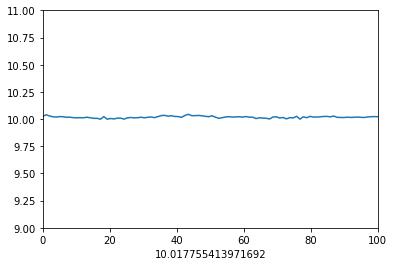

In [15]:
# plot the distance between consecutive points of the curve
#%matplotlib notebook
%matplotlib inline
fig = plt.figure()
bx = fig.add_subplot(111)
bx.axis(np.array([0,m,0.9*energy._L,1.1*energy._L]))
bx.set_xlabel(np.sum(energy._eval_lengths(points.coords)))
distance = plt.Line2D(np.linspace(0,m,m),m*energy._eval_lengths(points.coords))
bx.add_line(distance)

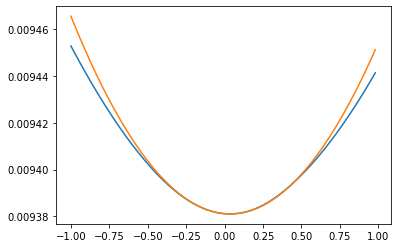

In [13]:
# compute the quadratic approximation to check the gradient and Hessian
%matplotlib inline
v=energy.grad(points)
v.coords = 0.0002*np.random.randn(m,3)
f,q, s = lorm.utils.eval_objective_function_with_quadratic_approximation(energy,v)
plt.plot(s,f,s,q)